## Objectif :
Construire un moteur de recherche d'image basé sur le systeme **CIBR (Content-Based Image Retrieval)**,il s’agit simplement d’une manière plus sophistiquée de «moteur de recherche d’images»,qui s’appuie strictement sur le contenu de l’image et non sur des annotations textuelles. associé à l'image.

## Les 4 étapes de tout système CBIR
Peu importe le système CIBR qu'on construise, ils peuvent tous être résumés en 4 étapes distinctes:
1. **Définition du descripteur de votre image**: à cette étape, on doit choisir l’aspect de l’image qu'on
souhaite décrire:**la couleur de l'image** ,**La forme d'un objet dans l'image** ou **la texture**
2. **Indexation de votre jeu de données**: Maintenant que le descripteur d’image est défini, notre tâche
consiste à appliquer ce descripteur à chaque image de votre jeu de données, à extraire les entités de ces
images et à les écrire dans la mémoire (fichier CSV, SGBDR, Redis, etc.). etc.) afin de pouvoir les comparer
ultérieurement pour la similarité.
3. **Définir votre métrique de similarité**: on a maintenant un ensemble de vecteurs d’entités. Mais
comment allons-nous les comparer? Les choix courants incluent la distance euclidienne, la distance cosinus
et la distance khi-carré, mais le choix réel dépend fortement **(1) de notre jeu de données** et **(2) des types
d'entités qu'on souhaite extraire.**
4. **Recherche**: La dernière étape consiste à effectuer une recherche réelle. Un utilisateur soumettra une
image de requête à votre système (à partir d'un formulaire de téléchargement ou via une application mobile,
par exemple) et notre travail consistera à **(1) extraire les fonctionnalités de cette image de requête**, puis **(2)
appliquer notre fonction de similarité pour comparer les fonctionnalités de requête aux fonctionnalités déjà
indexées**. À partir de là,on retourne simplement les résultats les plus pertinents en fonction de notre
fonction de similarité

In [17]:
#imporation des bibiotheques necessaires
import cv2
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean 
import matplotlib.pyplot as plt
import imutils
import glob

# 1- Recherche par image entière
L’objectif est d’afficher les 5 images les plus similaires à l’image requête **« Imrequest.jpg »** en se basant sur un calcul de différence entre images entières

In [10]:


def rechercheImageEntiere(Folder,imReq):
    dict_res={}
    
    imReq=cv2.cvtColor(imReq, cv2.COLOR_BGR2GRAY)#convertisse l'image requete en image de gris
    
    #lister les images contenues dans le dossier
    for imagePath in glob.glob(Folder+ "/*.jpg"):
        
         #recupere le nom de l'image courant
        image = cv2.imread(imagePath) #lecture de l'image courant
        
        image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convertisse l'image courant en image de gris
        
        diff=np.abs(np.subtract(imReq,image)) #soustraction de l'image courant avec l'image requete
        
        vect_zero=diff[diff==0] #compte le nombre de 0 contenu contenu dans la matrice diff et retourne ça sous forme d'une liste
        
        nb_zero=9600-vect_zero.size #calcule le nb de zero contenue dans la matrice de diff
        
        #on stocke le path de chaque image du dataset avec le nb de 0 du matrice de sa matrice de soustration avec
        #l'image requete dans un dictionnaire sous forme de clé-valeur 
        
        dict_res.setdefault(imagePath,nb_zero)
        
    return dict_res



In [11]:
def requete(dataset,imageRequest,n=5):
    
    imReq=cv2.imread(imageRequest) #lecture de l'image requete
    
    dict_res=rechercheImageEntiere(dataset,imReq) 
    
    #trie du dictionnaire selon le nombre de zero
    
    res_sorted=sorted(dict_res.items(),key = lambda x : x[1] )
    
    #recuperation des 5 premiere images les plus similaires
    
    res=res_sorted[:n]
    
    #affichage des ces n premieres image similaires
    
    fig=plt.figure(figsize=(20,20))
    plt.subplot(n-1,2,1)
    
    plt.imshow(imReq) #affichage de l'image Requete
    
    plt.title("Image Requete")
    plt.axis("off")
    
    i=3

    for key,value in res:
        im=cv2.imread(key)
        
        plt.subplot(n-1,2,i)
        plt.imshow(im)
        plt.title("Image Similaire ")
        plt.axis("off")
        i=i+1
        

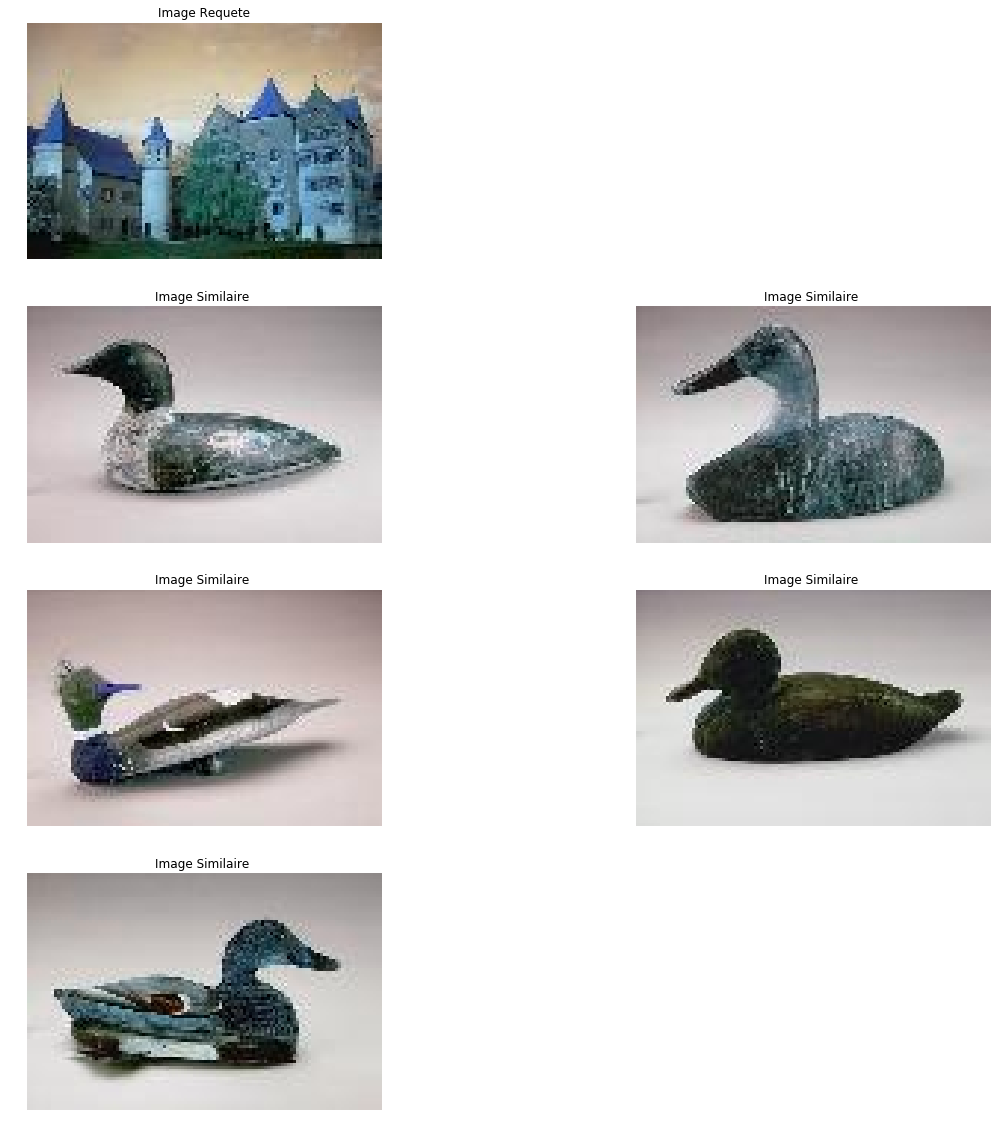

In [12]:
#TEST

dataset="DataSet" #Dossiers contenant les images
imageRequete="ImageRequete.jpg"  #image requete

requete(dataset,imageRequete)


# 2- Recherche par couleur :

Extraire les caractéristiques couleurs des images du dataset et creer une base d'index afin de l’utiliser dans chaque recherche
effectuée par similarité entre caractéristiques de l’image requête et caractéristiques de la base d’index.

Le vecteur descripteur couleur à utilise est constitué des valeurs des moments statistiques ;
moyenne et variance de chaque composante couleur R, G et B. La taille du vecteur sera donc 6.

In [13]:
#fonction qui extrait les 2 primeirs moments (mean et std) de chaque composante R,G,B d'une image

def getMoments(image):
    
    #extraction des composants RGB de l'image
    R=image[:,:,0]
    G=image[:,:,1]
    B=image[:,:,2]
    
    #calcule des moyennes et des ecart-type de chaque composants
    colorFeature=[np.round(R.mean()),np.round(R.std()),np.round(G.mean()),np.round(G.std()),
                  np.round(B.mean()),np.round(B.std())]
    
    #normalisation
    colorFeature=colorFeature/np.array(colorFeature).mean()
    
    return colorFeature

In [18]:
def CIBR_Recherche(Folder,imageRequete):
    
    imReq_features=getMoments(imageRequete) #extraction du vecteur descripteur de l'image requete
    
     #dictionnaire qui va contenir les distances eucludiennes % a l'image requete et le nom des image de dataset
    dict_distance={}
    
    #lister les images contenues dans le dossier
    for imagePath in glob.glob(Folder+ "/*.jpg"):
        
        #recupere le nom de l'image courant
        image = cv2.imread(imagePath) #lecture de l'image courant
        
        feature=getMoments(image) #recupere le vecetur descripteurs de l'image courant
        
        #calcule la distance euclidienne des vecteurs descripteurs de l'image courant du dataset et l'image requete
        
        distance= euclidean(imReq_features,feature)
        
        
        #ajoute la distance eucludienne et la path de l'image dans comme cle-valeur dans le dictionnaire
        
        dict_distance.setdefault(imagePath,distance) 
        
    return dict_distance;
        

In [19]:
def requete_RechercheCouleur(dataset,imageRequest,n=5):
    
    im_req=cv2.imread(imageRequest) #lecture de l'image requete
    
    dict_res=CIBR_Recherche(dataset,imageRequete=im_req) 
    
    #trie du dictionnaire selon les distances eucludienne
    
    res_sorted=sorted(dict_res.items(),key = lambda x : x[1] )
    
    #recuperation des 5 premiere images les plus similaires
    
    res=res_sorted[:n]
    
    #affichage des ces n premieres image similaires
    
    fig=plt.figure(figsize=(20,20))
    plt.subplot(n-1,2,1)
    
    plt.imshow(im_req) #affichage de l'image Requete
    
    plt.title("Image Requete")
    plt.axis("off")
    
    i=3

    for key,value in res:
        im=cv2.imread(key)
        
        plt.subplot(n-1,2,i)
        plt.imshow(im)
        plt.title("Image Similaire : "+key.split('\\')[1])
        plt.axis("off")
        i=i+1

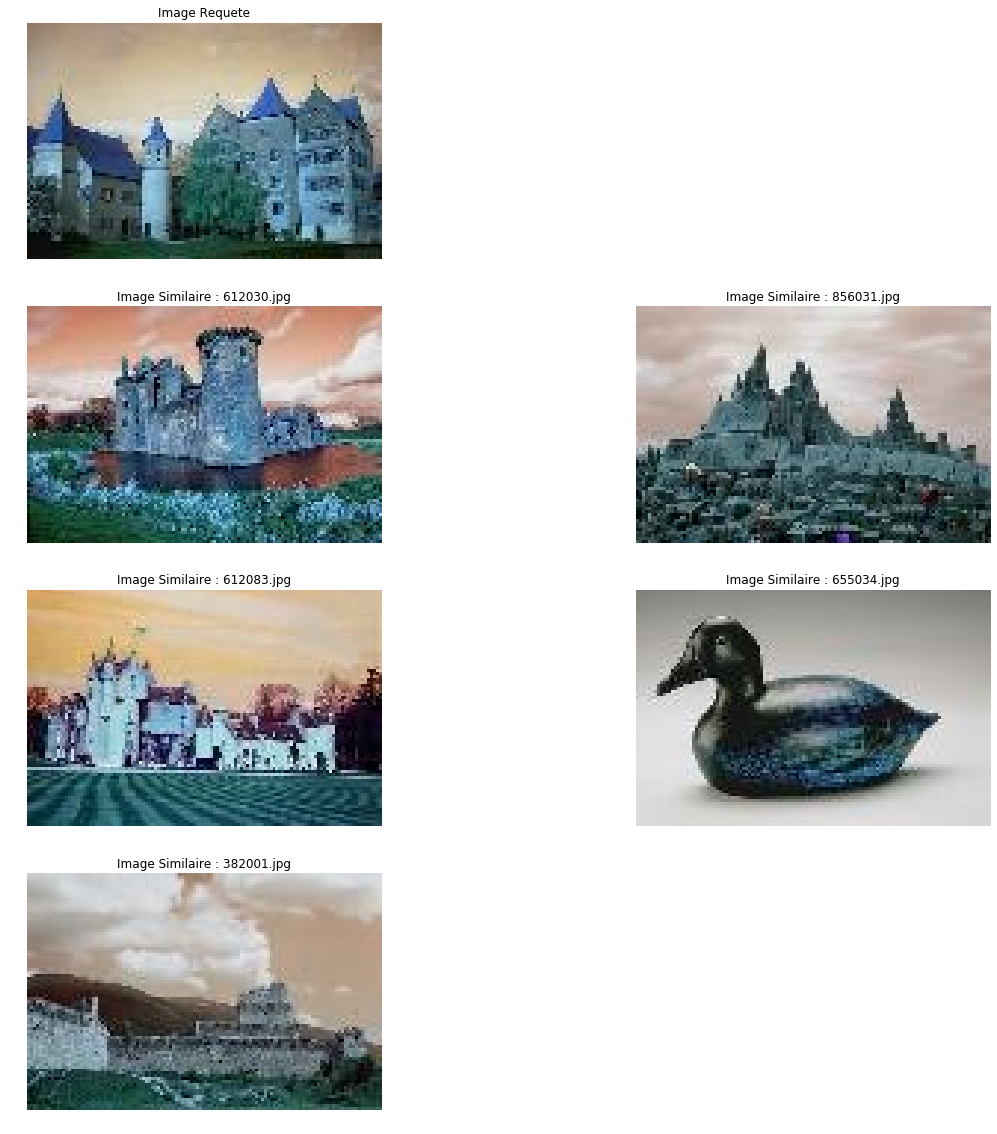

In [20]:
#TEST

dataset="DataSet" #Dossiers contenant les images
imageRequete="ImageRequete.jpg"  #image requete

requete_RechercheCouleur(dataset,imageRequete)

# 3- Recherche par Histogramme :

Nous utiliserons un descripteur d'image simple mais efficace: **l'histogramme de couleur** .
En utilisant un histogramme de couleur comme descripteur d'image, nous nous baserons sur la distribution des couleurs de l'image. Pour cette raison, nous devons faire une hypothèse importante concernant notre moteur de recherche d'images:

**les images ayant des distributions de couleurs similaires seront considérées comme pertinentes les unes par rapport aux autres. Même si les images ont un contenu radicalement différent, elles seront toujours considérées comme «similaires», à condition que leurs distributions de couleurs soient également similaires.**

Des recherches scientifiques ont montré que l’espace de couleur **HSV** est le plus adapté à ce type de système de recherche

In [22]:
#fonction qui quantifie l'histogramme dans un espace couleur hsv en 8x2x2 cases identiques
#L'Histogramme dans l'espace de couleur HSV est obtenu utilisant une quantification par niveau:
# 8 pour H(hue), 2 pour S(saturation), et 2 pour V(Value).
# Le vecteur descripteur de taille 1x32 est calculé puis normalisé

def hsvHistogram(image):
    
    #convertir l'image RGB en HSV
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    

    bins=(8,2,2)
    
    hist = cv2.calcHist([image], [0, 1, 2],None, bins,
                        [0, 256, 0, 256, 0, 256])
    
    #normalisation des histogrammes de couleur afin que chaque histogramme soit représenté par le nombre de pourcentages 
    #relatifs pour un groupe particulier et non par le nombre entier pour chaque groupe.La normalisation garantira que les images 
    #ayant un contenu similaire mais des dimensions radicalement différentes seront toujours «similaires» une fois que nous
    #aurons appliqué notre fonction de similarité
    
    if imutils.is_cv2():
        hist = cv2.normalize(hist).flatten()# otherwise handle for OpenCV 3+
    else:
        hist = cv2.normalize(hist, hist).flatten()
        # return the histogram

    return hist


In [23]:
#fonction qui retourne les deux vecteurs descripteurs de moments et d’histogramme.

def getFeatures(image):
    
    #concatenation du vecteurs de moments avec l'histogramme
    features= np.concatenate((getMoments(image),hsvHistogram(image)))
    
    
    
    return features
    

In [24]:
def CIBR_HSVHistogramme(Folder,imageRequete):
    
    imReq_features=getFeatures(imageRequete) #extraction du vecteur descripteur de l'image requete
    
     #dictionnaire qui va contenir les distances eucludiennes % a l'image requete et le nom des image de dataset
    dict_distance={}
    
    #lister les images contenues dans le dossier
    for imagePath in glob.glob(Folder+ "/*.jpg"):
        
        #recupere le nom de l'image courant
        image = cv2.imread(imagePath) #lecture de l'image courant
        
        feature=getFeatures(image) #recupere le vecetur descripteurs de l'image courant
        
        #calcule la distance euclidienne des vecteurs descripteurs de l'image courant du dataset et l'image requete
        
        distance= euclidean(imReq_features,feature)
        
        
        #ajoute la distance eucludienne et la path de l'image dans comme cle-valeur dans le dictionnaire
        
        dict_distance.setdefault(imagePath,distance) 
        
    return dict_distance;

In [25]:
def requete_HSVHistRech(dataset,imageRequest,n=5):
    
    im_req=cv2.imread(imageRequest) #lecture de l'image requete
    
    dict_res=CIBR_HSVHistogramme(dataset,im_req) 
    
    #trie du dictionnaire selon les distances eucludienne
    
    res_sorted=sorted(dict_res.items(),key = lambda x : x[1] )
    
    #recuperation des 5 premiere images les plus similaires
    
    res=res_sorted[:n]
    
    #affichage des ces n premieres image similaires
    
    fig=plt.figure(figsize=(20,20))
    plt.subplot(n-1,2,1)
    
    plt.imshow(im_req) #affichage de l'image Requete
    
    plt.title("Image Requete")
    plt.axis("off")
    
    i=3

    for key,value in res:
        im=cv2.imread(key)
        
        plt.subplot(n-1,2,i)
        plt.imshow(im)
        plt.title("Image Similaire : "+key.split('\\')[1])
        plt.axis("off")
        i=i+1

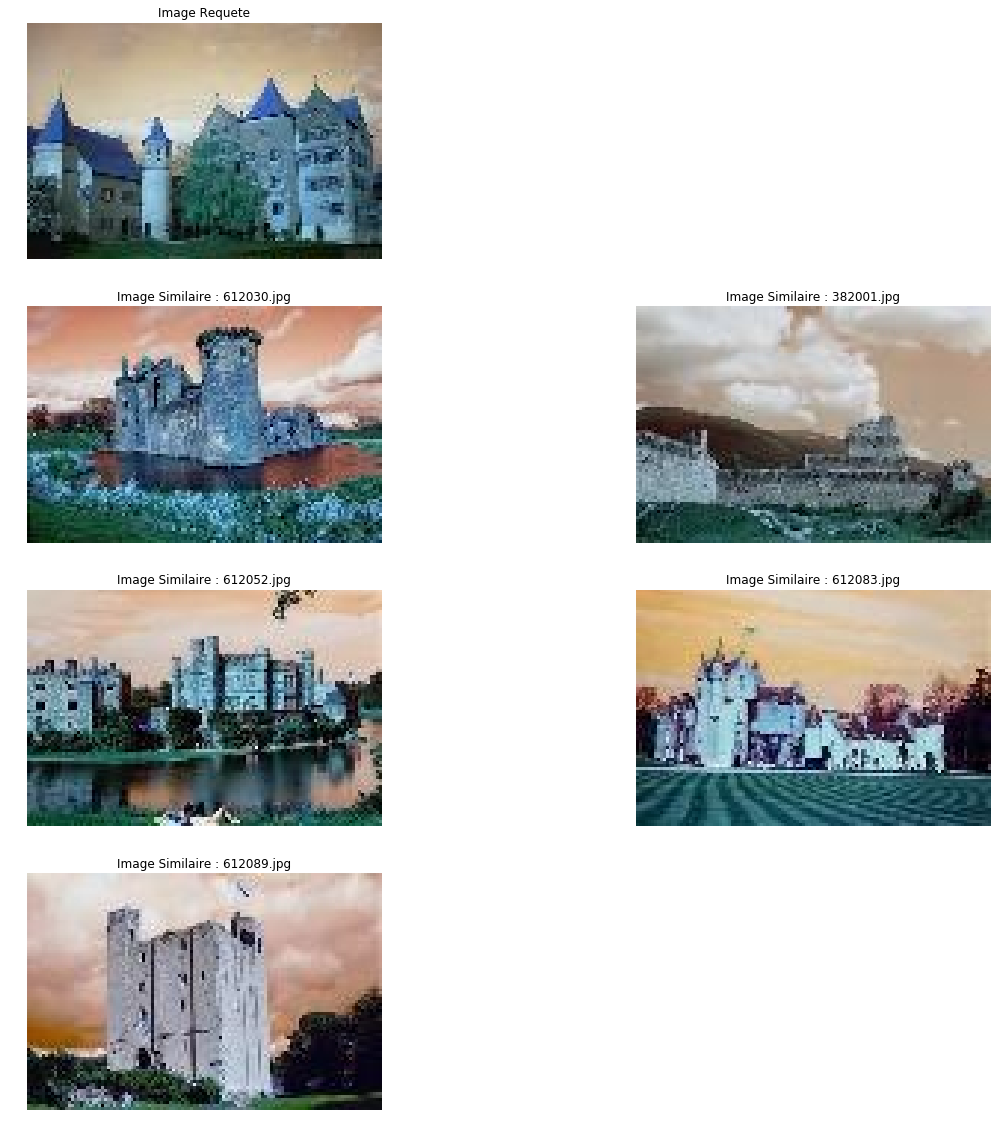

In [26]:
#TEST

dataset="DataSet" #Dossiers contenant les images
imageRequete="ImageRequete.jpg"  #image requete

requete_HSVHistRech(dataset,imageRequete)

# 4- Recherche par texture :

On cree un descripteur de texture de taille 4 et qui va contenir **la contraste, la corrélation, l’énergie** et **l’homogénéité**. Ces 4 informations sont très utilisées dans ce type de système et qui sont des mesures statistiques extraites de **la matrice de cooccurrence de niveau de gris (GLCM, Gray Level Co-occurrence Matrix)** également appelée matrice de dépendance spatiale de niveau de gris.

Les fonctions GLCM caractérisent la texture d'une image en calculant la fréquence à laquelle des paires de pixels avec des valeurs spécifiques et dans une relation spatiale spécifiée se produisent dans une image, en créant un GLCM, puis en extrayant des mesures statistiques de cette matrice.

En ajoutant la caractéristique texture aux deux autres caractéristiques (**moments et histogrammes**), nous aurons un vecteur descripteur de taille 1x42.

In [27]:
from skimage.feature import greycomatrix, greycoprops

def textureFeature(image):
    
    lf = []
    
    img=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    props = ['contrast', 'correlation', 'homogeneity', 'energy',]

    # left nearest neighbor
    glcm = greycomatrix(img, [1], [0], 256, symmetric=True, normed=True)
    
    for f in props:
        lf.append( greycoprops(glcm, f)[0,0] )
        
    
    lf=np.asarray(lf)
    #les amener dans la même echelle : H(i)=-sign(H(i))*log(H(i))
    
    #amenons dans la même echelle les valeurs du vecteurs avec la formule : H(i)=-sign(H(i))*log(H(i))
    for i in range(lf.size):
        lf[i] = -1*np.copysign(1.0,lf[i]) * np.log10(abs(lf[i]))
        
    return lf

In [28]:
#fonction qui retourne les vecteurs descripteurs de moments,d’histogramme et du texture de l'image

def getAllFeatures(image):
    
    #concatenation du vecteurs de moments avec l'histogramme
    features= np.concatenate((getMoments(image),hsvHistogram(image),textureFeature(image)))
    

    
    return features

In [29]:
def CIBR_Texture(Folder,imageRequete):
    
    imReq_features=getAllFeatures(imageRequete) #extraction du vecteur descripteur de l'image requete
    
     #dictionnaire qui va contenir les distances eucludiennes % a l'image requete et le nom des image de dataset
    dict_distance={}
    
    #lister les images contenues dans le dossier
    for imagePath in glob.glob(Folder+ "/*.jpg"):
        
        #recupere le nom de l'image courant
        image = cv2.imread(imagePath) #lecture de l'image courant
        
        feature=getAllFeatures(image) #recupere le vecetur descripteurs de l'image courant
        
        #calcule la distance euclidienne des vecteurs descripteurs de l'image courant du dataset et l'image requete
        
        distance= euclidean(imReq_features,feature)
        
        
        #ajoute la distance eucludienne et la path de l'image dans comme cle-valeur dans le dictionnaire
        
        dict_distance.setdefault(imagePath,distance) 
        
    return dict_distance;

In [30]:
def requete_Texture(dataset,imageRequest,n=5):
    
    im_req=cv2.imread(imageRequest) #lecture de l'image requete
    
    dict_res=CIBR_Texture(dataset,im_req) 
    
    #trie du dictionnaire selon les distances eucludienne
    
    res_sorted=sorted(dict_res.items(),key = lambda x : x[1] )
    
    #recuperation des 5 premiere images les plus similaires
    
    res=res_sorted[:n]
    
    #affichage des ces n premieres image similaires
    
    fig=plt.figure(figsize=(20,20))
    plt.subplot(n-1,2,1)
    
    plt.imshow(im_req) #affichage de l'image Requete
    
    plt.title("Image Requete")
    plt.axis("off")
    
    i=3

    for key,value in res:
        im=cv2.imread(key)
        
        plt.subplot(n-1,2,i)
        plt.imshow(im)
        plt.title("Image Similaire : "+key.split('\\')[1])
        plt.axis("off")
        i=i+1

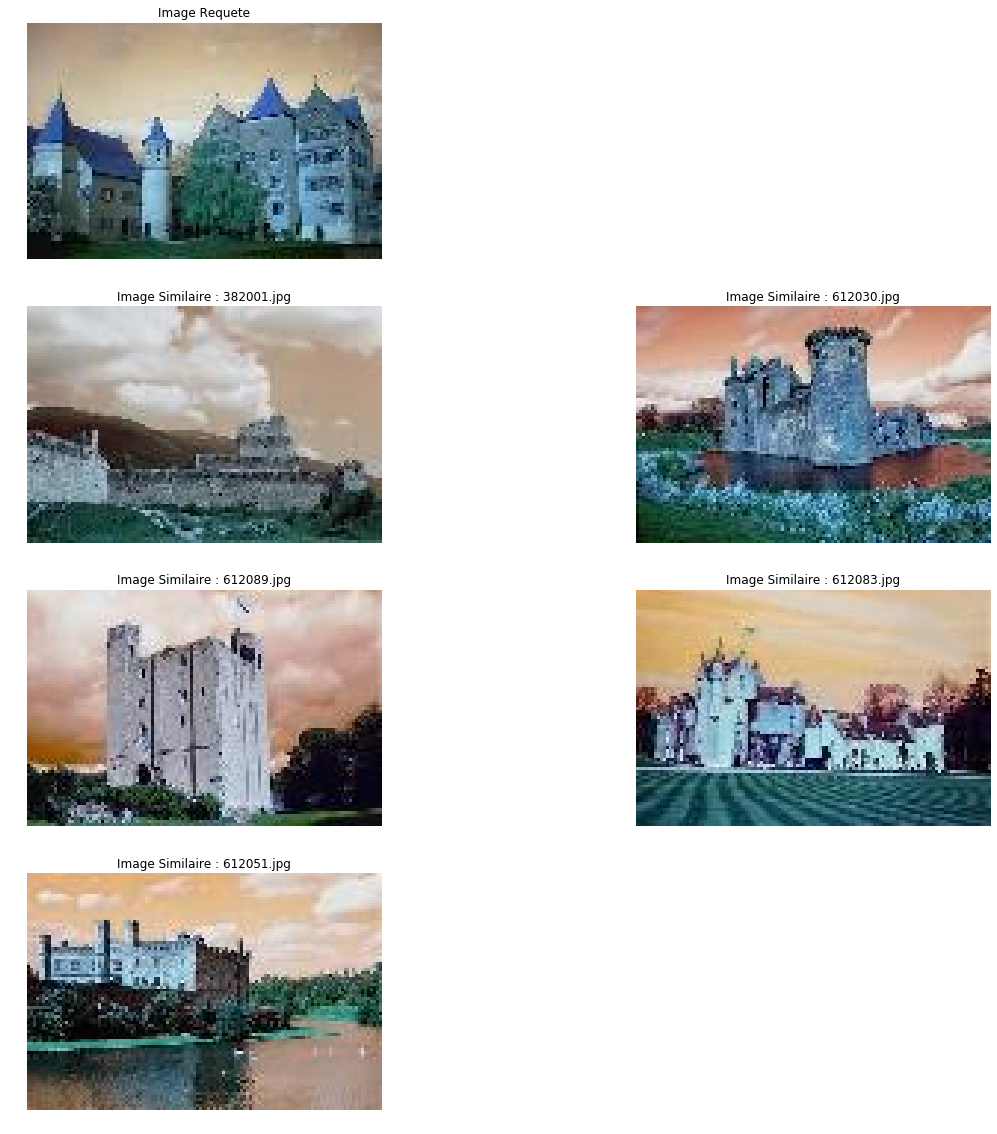

In [31]:
#TEST

dataset="DataSet" #Dossiers contenant les images
imageRequete="ImageRequete.jpg"  #image requete

requete_Texture(dataset,imageRequete)

# 5- Recherche par la forme

L'objectif est de creer un vecteur descripteur de forme et le concaténer avec les 3 caractéristiques utilisées auparavant pour voir son impact sur le résultat de recherche. Le
vecteur descripteur de forme de taille 1x7 utilisé sera créé à partir des moments invariants de Hu.

Les moments Hu sont un ensemble de 7 nombres calculés à l'aide de moments centraux invariants des transformations d'image. Les 6 premiers moments se sont avérés invariants en **translation , en ampleur , en rotation et en réflexion** . Alors que le signe du 7ème moment change pour **la réflexion** de l'image.

In [48]:
def shapeFeatures(image):
    
    #convertisse l'image en image de gris
    
    img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    
    #Calculer les moments de Hu
    moments = cv2.moments(img)
    
    huMoments = cv2.HuMoments(moments)
    
    #les moments de Hu peuvent etre dans des echelles differents,une transformation de log donnée ci-dessous peut
    #les amener dans la même echelle : H(i)=-sign(H(i))*log(H(i))
    
    
    for i in range(0,7):
        huMoments[i] = -1*np.copysign(1.0,huMoments[i]) * np.log10(abs(huMoments[i]))
    
    #redimension 
    huMoments.reshape(7,)
    return huMoments
    
    

In [49]:
#fonction qui retourne les vecteurs descripteurs de moments,d’histogramme,du texture de l'image et de la forme

def getAllFeaturesShape(image):
    
    #concatenation du vecteurs de moments avec l'histogramme
    moments=getMoments(image)
    hist=hsvHistogram(image)
    texture=textureFeature(image)
    shape=shapeFeatures(image)
    
    features= np.concatenate((moments,hist,texture,shape.reshape(7)))
    

    
    return features

In [50]:
def CIBR_Shape(Folder,imageRequete):
    
    imReq_features=getAllFeaturesShape(imageRequete) #extraction du vecteur descripteur de l'image requete
    
     #dictionnaire qui va contenir les distances eucludiennes % a l'image requete et le nom des image de dataset
    dict_distance={}
    
    #lister les images contenues dans le dossier
    for imagePath in glob.glob(Folder+ "/*.jpg"):
        
        #recupere le nom de l'image courant
        image = cv2.imread(imagePath) #lecture de l'image courant
        
        feature=getAllFeaturesShape(image) #recupere le vecetur descripteurs de l'image courant
        
        #calcule la distance euclidienne des vecteurs descripteurs de l'image courant du dataset et l'image requete
        
        distance= euclidean(imReq_features,feature)
        
        
        #ajoute la distance eucludienne et la path de l'image dans comme cle-valeur dans le dictionnaire
        
        dict_distance.setdefault(imagePath,distance) 
        
    return dict_distance;

In [59]:
def requete_Shape(dataset,imageRequest,n=5):
    
    im_req=cv2.imread(imageRequest) #lecture de l'image requete
    
    dict_res=CIBR_Shape(dataset,im_req) 
    
    #trie du dictionnaire selon les distances eucludienne
    
    res_sorted=sorted(dict_res.items(),key = lambda x : x[1] )
    
    #recuperation des 5 premiere images les plus similaires
    
    res=res_sorted[:n]
    
    #affichage des ces n premieres image similaires
    
    fig=plt.figure(figsize=(20,20))
    plt.subplot(n-1,2,1)
    
    plt.imshow(im_req) #affichage de l'image Requete
    
    plt.title("Image Requete")
    plt.axis("off")
    
    i=3

    for key,value in res:
        im=cv2.imread(key)
        
        plt.subplot(n-1,2,i)
        plt.imshow(im)
        plt.title("Image Similaire : "+key.split('\\')[1])
        plt.axis("off")
        i=i+1

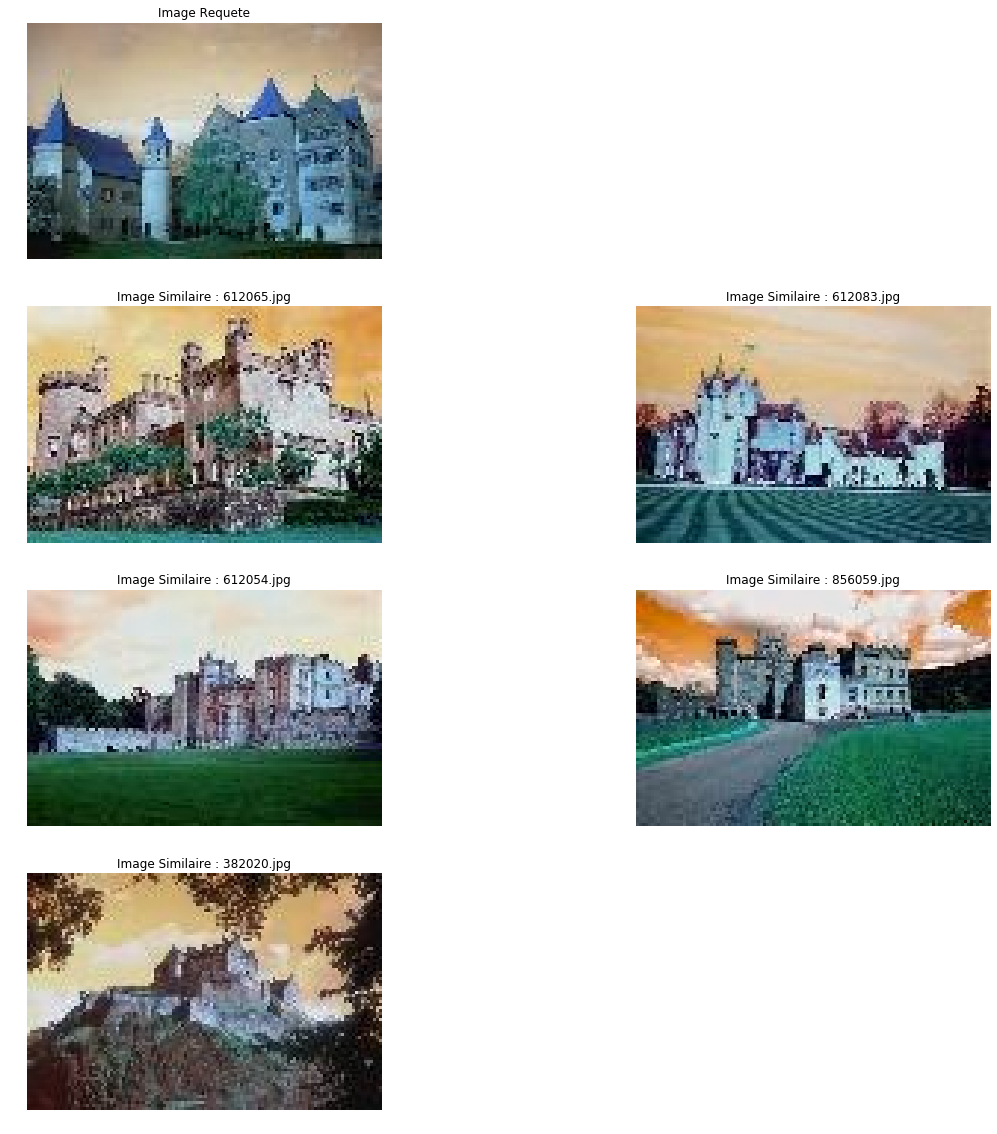

In [64]:
#TEST

dataset="DataSet" #Dossiers contenant les images
imageRequete="ImageRequete.jpg"  #image requete

requete_Shape(dataset,imageRequete,n=5)